In [92]:
# @author: Potluri Sai Rakshith
# @email: Potluri.Rakshith@ril.com


In [1]:
from pycaret.classification import *


In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, roc_curve
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap

In [3]:
pd.set_option('display.max_colwidth', None)
pd.set_option('float_format', '{:f}'.format)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [32]:
sample_ration = 0.50

In [49]:
data = (pd.read_csv("/Users/potluri.rakshith/Work/master_data_modelling/tp_device_data_app/scaled_data.csv", low_memory = False))#.drop(columns = ['target_download_throughput'])

In [50]:
model_path = "/Users/potluri.rakshith/Work/master_data_modelling/tp_device_data_app/streaming_data_50p_all_feats"

In [51]:
data.shape

(4319354, 44)

In [52]:
data.entity_appn_group.value_counts(normalize = True)

STREAMING   0.661850
Social      0.221303
WEB         0.116847
Name: entity_appn_group, dtype: float64

## Application Selection

In [53]:
data = data[data['entity_appn_group'] == 'STREAMING']
data.shape

(2858764, 44)

In [54]:
data = data.sample(frac = sample_ration, random_state = 43)

In [55]:
data.shape

(1429382, 44)

In [56]:
data.isnull().sum() / data.shape[0] * 100

entity_appn_group                       0.000000
entity_cell_id                          0.000000
entity_geohash7                         0.000000
entity_imsi                             0.000000
fifth_minute                            0.000000
gh7_avg_cqi                             0.000000
gh7_avg_pucch_sinr                      0.000000
gh7_avg_pusch_sinr                      0.000000
gh7_avg_rsrp                            0.000000
gh7_avg_rsrq                            0.000000
gh7_avg_ta_isd_ratio                    0.000000
gh7_avg_uplink_interference             0.000000
gh7_erab_drops_pct                      0.000000
gh7_erab_normal_releases_pct            0.000000
gh7_fd_dropped_connection               0.000000
gh7_fd_normal_release                   0.000000
gh7_fd_outgoing_ho                      0.000000
gh7_lhd_success_pct                     0.000000
gh7_num_of_neighbors                    0.000000
gh7_ta                                  0.000000
gh7_tot_download_dat

## Feature and Target Selection

In [57]:
target = 'good_download_throughput'
target_metric = 'target_download_throughput'

In [58]:
data[target] = pd.cut(data[target_metric], [-float("inf"), 512, float("inf")], labels = [0, 1])
data[target] = data[target].astype(int)   
data[target].value_counts(normalize = True)

0   0.665974
1   0.334026
Name: good_download_throughput, dtype: float64

In [59]:
data.columns

Index(['entity_appn_group', 'entity_cell_id', 'entity_geohash7', 'entity_imsi', 'fifth_minute', 'gh7_avg_cqi', 'gh7_avg_pucch_sinr', 'gh7_avg_pusch_sinr', 'gh7_avg_rsrp', 'gh7_avg_rsrq', 'gh7_avg_ta_isd_ratio', 'gh7_avg_uplink_interference', 'gh7_erab_drops_pct', 'gh7_erab_normal_releases_pct', 'gh7_fd_dropped_connection', 'gh7_fd_normal_release', 'gh7_fd_outgoing_ho', 'gh7_lhd_success_pct', 'gh7_num_of_neighbors', 'gh7_ta', 'gh7_tot_download_data_volume', 'gh7_tot_rrc_re_establishment_attempts', 'gh7_tot_upload_data_volume', 'hss_device_price', 'lsmr_airmac_ul_throughput', 'lsmr_avg_rrc_conn_count', 'lsmr_prb_util_dl', 'lsmr_prb_util_ul', 'lsr_avg_cqi', 'lsr_avg_pusch_sinr', 'lsr_avg_rsrp', 'lsr_avg_rsrq', 'lsr_avg_start_ta', 'lsr_avg_ta_isd_ratio', 'lsr_avg_uplink_interference', 'lsr_erab_normal_releases_pct', 'lsr_erab_successes_pct', 'lsr_fd_normal_release_pct', 'lsr_fd_outgoing_ho_pct', 'lsr_lhd_success_pct', 'lsr_num_of_neighbors', 'lsr_ta', 'target_download_throughput',
       '

In [60]:
drop_cols = ['entity_appn_group', 'entity_cell_id', 'entity_geohash7', 'entity_imsi', 'fifth_minute',
             'target_download_throughput','target_upload_throughput']
data.drop(columns = drop_cols, inplace = True)

In [61]:
data.shape

(1429382, 38)

## Train Test Split

In [63]:
state = 43
ratio = 0.05
train, test = train_test_split(data, test_size = ratio, random_state = state)

In [64]:
train.shape, test.shape

((1357912, 38), (71470, 38))

In [65]:
train.good_download_throughput.value_counts(normalize = True)

0   0.666063
1   0.333937
Name: good_download_throughput, dtype: float64

In [66]:
test.good_download_throughput.value_counts(normalize = True)

0   0.664279
1   0.335721
Name: good_download_throughput, dtype: float64

In [67]:
# target = "good_download_throughput"
import copy
features = copy.deepcopy(list(data.columns))
features.remove(target)

# Training Setup

In [68]:
clf1 = setup(data = train, target = target, session_id = state, numeric_features= features, silent = True)

,Description,Value
0,session_id,43
1,Target,good_download_throughput
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(1357912, 38)"
5,Missing Values,False
6,Numeric Features,37
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [69]:
best_specific = compare_models(include = ['lightgbm'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7807,0.8546,0.6617,0.6750,0.6683,0.5046,0.5046,3.7300


In [70]:
best_specific

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=43, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [71]:
tuned_model = tune_model(best_specific, n_iter = 5, optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7836,0.8583,0.6691,0.6784,0.6737,0.5119,0.5119
1,0.7821,0.8573,0.6676,0.6757,0.6716,0.5085,0.5085
2,0.7841,0.8590,0.6717,0.6784,0.6750,0.5134,0.5134
3,0.7822,0.8566,0.6673,0.6760,0.6716,0.5086,0.5087
4,0.7824,0.8557,0.6697,0.6756,0.6726,0.5097,0.5097
5,0.7839,0.8590,0.6713,0.6782,0.6747,0.5130,0.5130
6,0.7825,0.8563,0.6676,0.6765,0.6720,0.5093,0.5093
7,0.7816,0.8564,0.6654,0.6756,0.6704,0.5071,0.5072
8,0.7824,0.8573,0.6680,0.6761,0.6720,0.5092,0.5092
9,0.7839,0.8580,0.6698,0.6787,0.6742,0.5125,0.5126


In [72]:
save_model(tuned_model, model_path)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['gh7_avg_cqi',
                                                           'gh7_avg_pucch_sinr',
                                                           'gh7_avg_pusch_sinr',
                                                           'gh7_avg_rsrp',
                                                           'gh7_avg_rsrq',
                                                           'gh7_avg_ta_isd_ratio',
                                                           'gh7_avg_uplink_interference',
                                                           'gh7_erab_drops_pct',
                                           

In [73]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
 

def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p) 
    plt.figure(figsize=(5,5))
    sns.heatmap(cm / predictions.shape[0], annot=True)
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    print('Sample Size ', len(labels))
    print('True Negatives ', cm[0][0])
    print('False Positives: ', cm[0][1])
    print('False Negatives: ', cm[1][0])
    print('True Positives: ', cm[1][1])
    
    print('Test Precision: ', ( cm[1][1] / (cm[1][1] + cm[0][1])))
    print('Test Recall: ', ( cm[1][1] / (cm[1][1] + cm[1][0])))
    print('Test Accuracy: ', ( (cm[1][1] + cm[0][0]) / (cm[1][1] + cm[1][0] + cm[0][0] + cm[0][1])))
    
    lr_precision, lr_recall, _ = precision_recall_curve(labels, predictions > p)
    lr_f1, lr_auc = f1_score(labels, predictions > p), roc_auc_score(labels, predictions)
     
    print('Test AUC: ', lr_auc )
    print('Test F1-Score: ', lr_f1 )

In [74]:
def derive_prob(row, target_label):
    if row['Label'] == target_label:
        return float(row['Score'])
    return (1 -  float(row['Score']))

def get_pycaret_probs(data, target_label):
    data['target_prediction'] = data.apply(lambda row : derive_prob(row, target_label = target_label), axis=1)
    return data

## Validation Data Results

In [75]:
train_predictions = get_pycaret_probs(predict_model(tuned_model), 1)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7828,0.8571,0.6709,0.6765,0.6737,0.5109,0.5109


In [76]:
train_predictions.head(10)

,gh7_avg_cqi,gh7_avg_pucch_sinr,gh7_avg_pusch_sinr,gh7_avg_rsrp,gh7_avg_rsrq,gh7_avg_ta_isd_ratio,gh7_avg_uplink_interference,gh7_erab_drops_pct,gh7_erab_normal_releases_pct,gh7_fd_dropped_connection,...,lsr_erab_successes_pct,lsr_fd_normal_release_pct,lsr_fd_outgoing_ho_pct,lsr_lhd_success_pct,lsr_num_of_neighbors,lsr_ta,good_download_throughput,Label,Score,target_prediction
0,-0.508563,0.072165,-0.225393,-0.861673,-0.631786,-0.211388,0.256949,0.023438,0.976562,0.021915,...,1.000000,1.000000,0.000000,0.000000,0.710795,-0.412650,0,0,0.641800,0.358200
1,0.500534,-0.091930,-0.217312,0.465091,-0.097975,-0.095590,0.519118,0.011936,0.988064,0.010595,...,0.000000,0.000000,1.000000,1.000000,1.856905,0.002077,0,0,0.939600,0.060400
2,-1.172228,-0.528230,-0.465431,-1.045822,-1.143182,-0.171111,-0.037177,0.023569,0.976431,0.014981,...,0.000000,0.000000,1.000000,1.000000,-0.435315,0.416805,0,0,0.996500,0.003500
3,0.143315,3.139776,1.598899,-2.476124,0.067232,-0.916244,-2.825175,0.000000,1.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,-0.435315,1.660987,0,0,0.959000,0.041000
4,-1.893011,-0.315871,-0.621812,-1.501204,-1.158955,0.347462,-0.644341,0.016393,0.983607,0.016575,...,0.000000,0.000000,1.000000,1.000000,-0.435315,0.416805,0,0,0.992000,0.008000
5,-1.863998,-0.306219,0.147261,0.047241,-1.760011,1.769760,1.108021,0.020305,0.979695,0.010989,...,1.000000,0.000000,1.000000,1.000000,-0.435315,0.002077,0,0,0.986900,0.013100
6,0.033611,1.224691,0.162947,-1.518029,-0.756314,-0.515987,-0.478039,0.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,-0.435315,0.002077,0,0,0.953300,0.046700
7,-0.379819,-0.620895,-0.408392,-0.487088,-0.381069,-0.241596,0.501510,0.019471,0.980529,0.013807,...,0.000000,0.000000,1.000000,1.000000,-0.435315,-0.205286,0,0,0.990800,0.009200
8,0.123369,0.045138,0.587886,2.118923,-0.337069,-0.583955,0.239992,0.009474,0.990526,0.005937,...,0.000000,0.000000,1.000000,1.000000,-0.435315,-0.205286,0,0,0.747200,0.252800
9,-0.226596,0.303829,0.954836,1.458315,-0.182655,0.508571,0.264774,0.014393,0.985607,0.008283,...,1.000000,1.000000,0.000000,0.000000,4.149125,-0.412650,1,1,0.516000,0.516000


In [77]:
train_predictions.shape

(407374, 41)

Sample Size  407374
True Negatives  227555
False Positives:  43678
False Negatives:  44812
True Positives:  91329
Test Precision:  0.6764760345759849
Test Recall:  0.6708412601640946
Test Accuracy:  0.7827794606430455
Test AUC:  0.8570699778407567
Test F1-Score:  0.6736468644430348


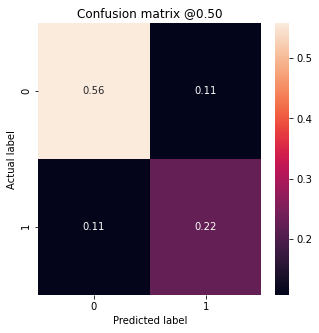

In [78]:
plot_cm((train_predictions['good_download_throughput'].astype(int)).to_numpy(),(train_predictions['target_prediction']*1.0).to_numpy(),p=0.5)

## Testing with Unseen Data

In [79]:
predictions = get_pycaret_probs(predict_model(tuned_model, data = test), 1)

In [80]:
predictions.head(2)

,gh7_avg_cqi,gh7_avg_pucch_sinr,gh7_avg_pusch_sinr,gh7_avg_rsrp,gh7_avg_rsrq,gh7_avg_ta_isd_ratio,gh7_avg_uplink_interference,gh7_erab_drops_pct,gh7_erab_normal_releases_pct,gh7_fd_dropped_connection,...,lsr_erab_successes_pct,lsr_fd_normal_release_pct,lsr_fd_outgoing_ho_pct,lsr_lhd_success_pct,lsr_num_of_neighbors,lsr_ta,good_download_throughput,Label,Score,target_prediction
128016,-0.018974,1.819294,1.129280,1.404142,-0.606880,-0.631784,0.145429,0.054054,0.945946,0.033803,...,1.000000,1.000000,0.000000,0.000000,-0.435315,-0.205286,0,1,0.737900,0.737900
4259037,-1.116922,-0.680741,-0.841887,-1.414121,-1.090050,-0.221458,-0.123263,0.018408,0.981592,0.013655,...,1.000000,1.000000,0.000000,0.500000,0.710795,-0.205286,0,0,0.664800,0.335200


In [81]:
predictions.shape

(71470, 41)

Sample Size  71470
True Negatives  39871
False Positives:  7605
False Negatives:  7849
True Positives:  16145
Test Precision:  0.6797894736842105
Test Recall:  0.6728765524714512
Test Accuracy:  0.7837694137400307
Test AUC:  0.8597801529854197
Test F1-Score:  0.6763153485254692


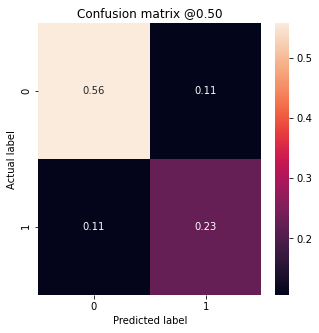

In [82]:
plot_cm((predictions['good_download_throughput'].astype(int)).to_numpy(),(predictions['target_prediction']*1.0).to_numpy(),p=0.5)

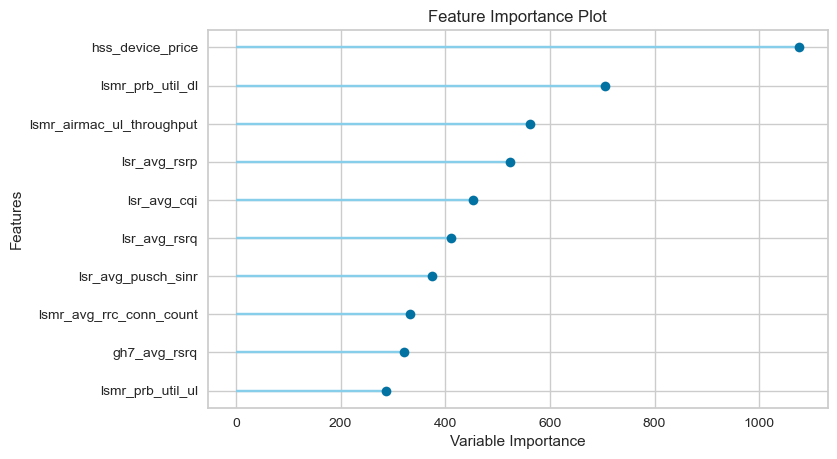

In [83]:
plot_model(tuned_model, plot='feature')

In [84]:
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [85]:
shap_test = test.head(500)
shap_test.drop(['good_download_throughput'],inplace=True,axis=1)


In [86]:
explainer = shap.TreeExplainer(tuned_model,shap_test)
shap_values = explainer.shap_values(shap_test)


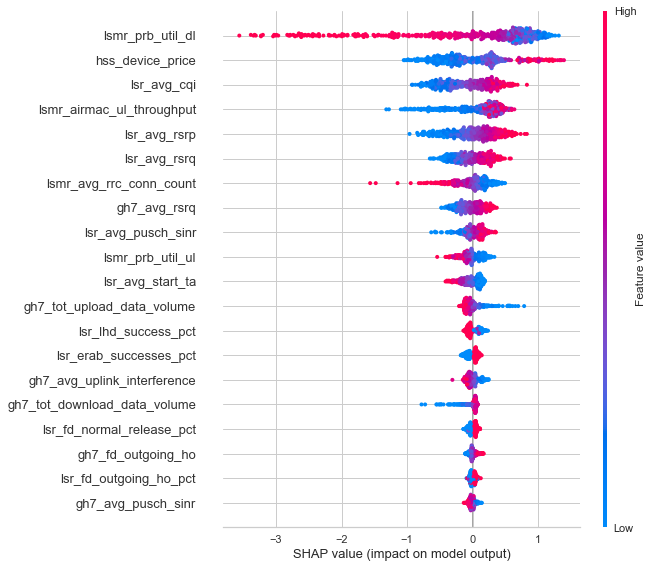

In [87]:
shap.initjs()
shap.summary_plot(shap_values,shap_test)

# High Score Predictions

Best Threshold=0.348700, G-Mean=0.783


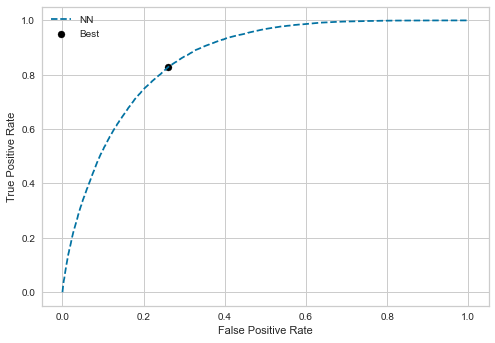

In [88]:
fpr, tpr, thresholds = roc_curve((predictions['good_download_throughput'].astype(int)).to_numpy(), 
                                 predictions['target_prediction'].astype(float).to_numpy())
# plot the roc curve for the model
# pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
plt.plot(fpr, tpr, linestyle='--', label='NN')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [89]:
def  get_threshold_cm(predictions, score_threshold, cm_threshold):

    predictions_high_score = predictions[predictions["Score"] > score_threshold]
    plot_cm((predictions_high_score['good_download_throughput'].astype(int)).to_numpy(),(predictions_high_score['target_prediction']*1.0).to_numpy(),p=cm_threshold)

Sample Size  71470
True Negatives  35132
False Positives:  12344
False Negatives:  4130
True Positives:  19864
Test Precision:  0.6167411823149528
Test Recall:  0.8278736350754355
Test Accuracy:  0.7694976913390233
Test AUC:  0.8597801529854197
Test F1-Score:  0.7068787587630333


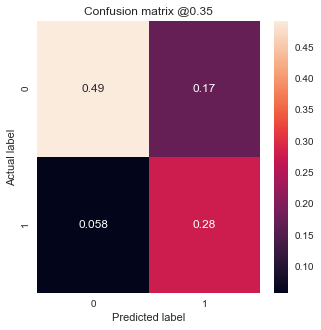

In [90]:
get_threshold_cm(predictions, thresholds[ix], thresholds[ix])

Sample Size  59568
True Negatives  36823
False Positives:  4807
False Negatives:  5265
True Positives:  12673
Test Precision:  0.725
Test Recall:  0.7064890177277289
Test Accuracy:  0.8309159280150417
Test AUC:  0.8868601773953988
Test F1-Score:  0.7156248235360552


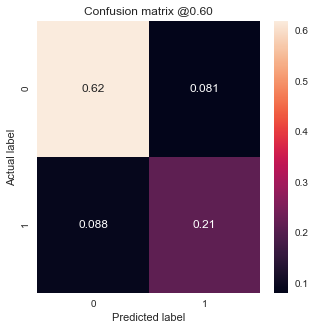

In [91]:
get_threshold_cm(predictions, 0.6, 0.6)